## Image Search Series Part 1: Chest X-ray Search with MedImageInsight (MI2)
In this tutorial, we show you how to build and optimize a 2D image search system for chest X-rays using **MedImageInsight embeddings**.

## Prerequisites

This notebook requires the following setup. If you haven't completed these steps, please refer to the Getting Started section in the main README, which includes:

1. Deploying required models
2. Installing the Healthcare AI Toolkit
3. Downloading sample data
4. Configuring your `.env` file

### Required for This Notebook

- **Model Endpoint(s)**: `MI2_MODEL_ENDPOINT` 
- **Additional Dependencies**: 
  ```bash
  conda install -c pytorch faiss-cpu
  ```

> **Note**: [FAISS](https://github.com/facebookresearch/faiss) provides efficient algorithms for searching large sets of vectors, making it perfect for building scalable image search systems like the one in this tutorial.

### 2D Image Search  
This tutorial walks you through the use of an embedding model to create a vector index and then build a system that woulod look up similar images based on image provided. We will first use out-of-the-box capabilities of MedImageInsight model to build a basic system, and then will enhance performance by applying some of the concepts introduced in other notebooks from this repository. In a prior [adapter training notebook](https://aka.ms/healthcare-ai-examples-mi2-adapter), we demonstrated how to train an adapter for classification. Here, we will also train a simple adapter to refine the MI2 model's embeddings to improve representation and then see how it improves performance. 

In either approach we will be building an index using FAISS library. Note that the index will need to be rebuilt if we are using different representations (like with the adapter approach). Once the FAISS index is built, we query it with a new embedding (query vector) to retrieve the most similar images. FAISS supports both exact and approximate nearest neighbor searches, allowing for a balance between speed and precision. In this tutorial, we use nearest neighbor search to find the most relevant images based on the query.

#### Steps in this Tutorial

1. **Set up and Data Preparation**
   - Authenticate with AzureML and load the online MI2 client.

2. **Compute Embeddings**
   - Generate embeddings for each image using the online REST API endpoint.
   - **Note:** Pre-computed embeddings are available for convenience.

3. **Create a Search Baseline Model**
   - **Build FAISS Index**  
     - Create a FAISS index using the MI2 embeddings.
   - **Evaluate and Display Search Results**  
     - Evaluate classification accuracy and compute precision @1, @3, and @5.
     - Visualize query images alongside their retrieved neighbors.

4. **Optimize the Search**
   - **Train the Adapter and Generate New Embeddings**  
     - Train an adapter model to refine the embeddings.
   - **Generate Optimized FAISS Index and Evaluate Search Results**  
     - Build a FAISS index using the optimized embeddings and evaluate the search results.
     - Visualize query images and their neighbors with the improved embeddings.

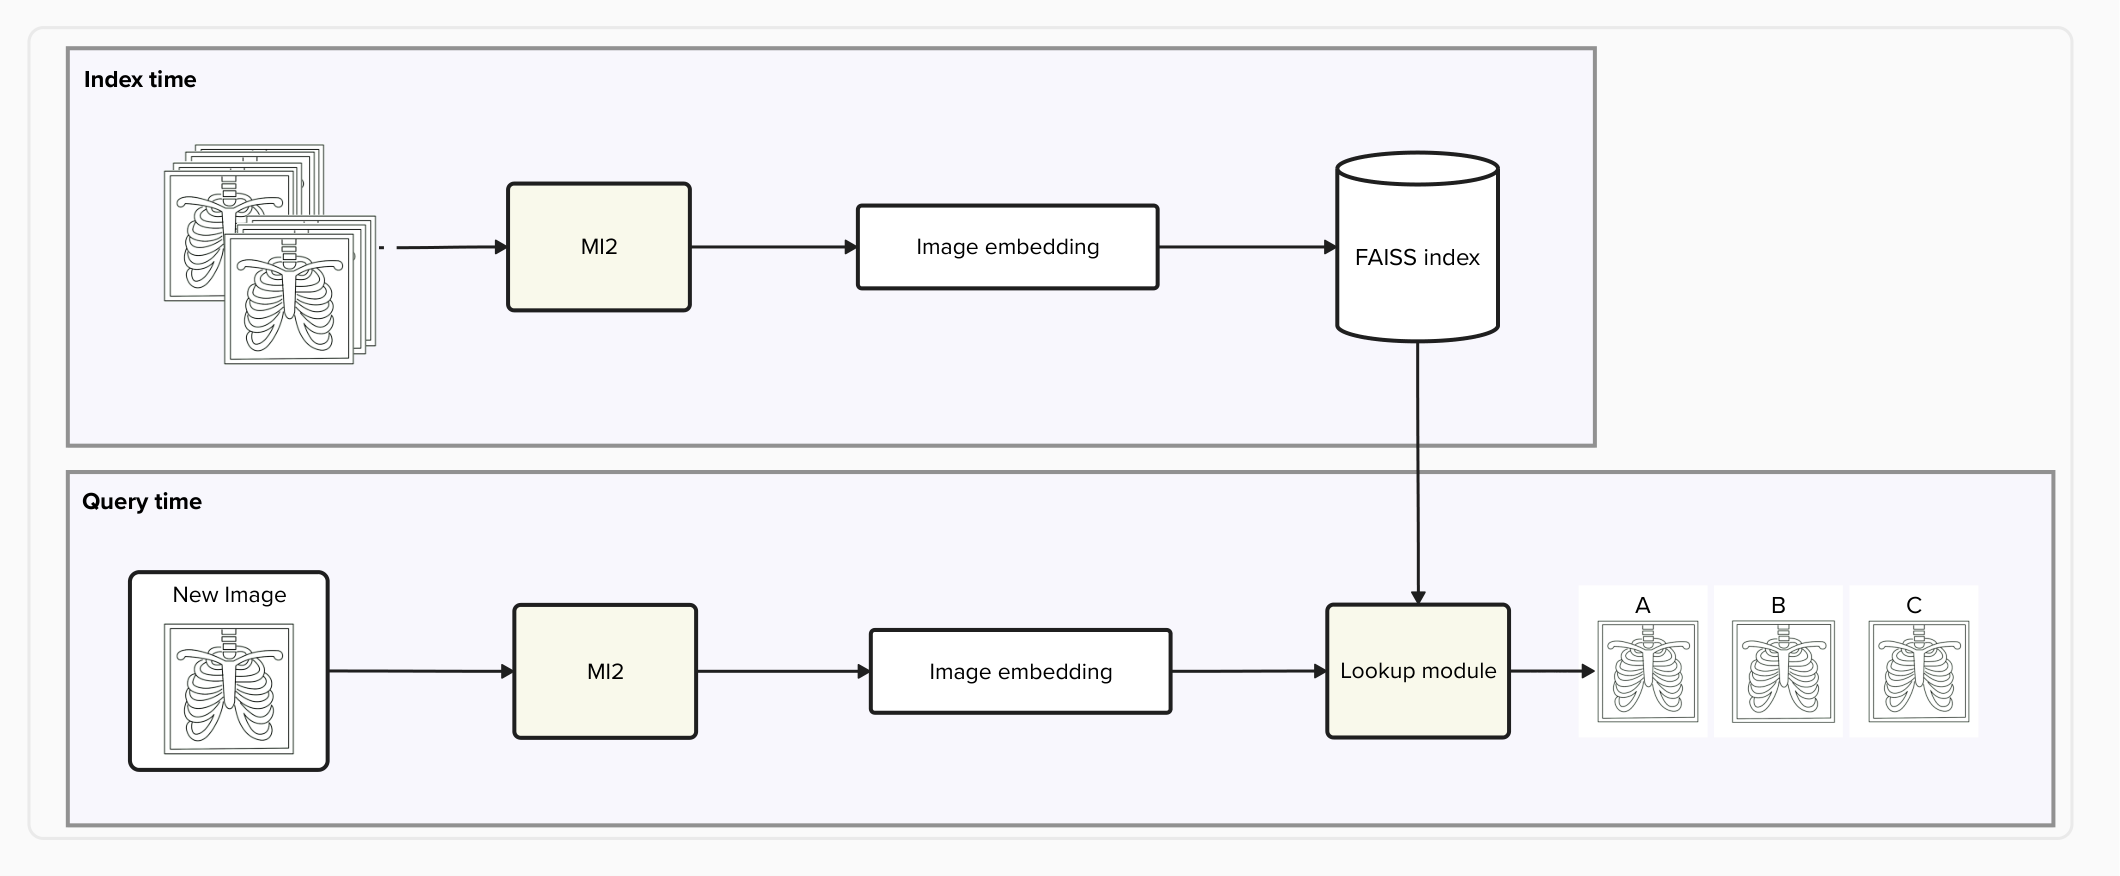

## **1. Set up and data preparation**

In [ ]:
## Load Packages for the tutorial
import pandas as pd
import torch
import os
import numpy as np

from model_library.utils import training
from model_library.embedding import AdapterModel

from healthcareai_toolkit import settings
from healthcareai_toolkit.clients import MedImageInsightClient

Point to the data directory.

In [ ]:
## Input Images and Text for Inference
data_root = settings.DATA_ROOT

if not os.path.exists(data_root):
    raise (
        Exception(
            f"Please download the files as described in this notebook into the data_root: {data_root}"
        )
    )

## Path for generating image embeddings
cx_image_path = os.path.join(data_root, "medimageinsight-classification", "images")
## Path to labels and splits
cx_csv_path = os.path.join(data_root, "medimageinsight-classification", "csv")

Set up and authenticate the endpoint

In [ ]:
from azure.ai.ml import MLClient
from azure.identity import DeviceCodeCredential

submit = False
if submit:
    # Authenticate with Azure ML
    credential = DeviceCodeCredential()
    ml_client = MLClient.from_config(credential)
    credential.authenticate()

## **2. Compute Embeddings**

> Note that while we walk you through generating the embeddings from source files, we also provide pre-computed embeddings in a .pkl file. 

### 2.1 Submit images to the MI2 model endpoint or load pre-computed embeddings
This code retrieves a list of DICOM image files, submits them to the model endpoint, and saves the resulting image data to a pickle file. **If the data is does not exist** in the `cx_image_path` directory, it will loads the embeddings from the pickle file for further processing. Consider using pre-computed embeddings if you don't want to wait until the all files are processed which may take a few minutes depending on your connection.

In [ ]:
import glob
import pickle

image_files = list(glob.glob(cx_image_path + "/*.dcm"))

# Define the path to save the pickle file
pkl_file_path = os.path.join(
    data_root, "medimageinsight-classification", "images_xray_mi2_embeddings.pkl"
)

# Connect to MI2 Endpoint (Optional )
if submit:
    # MI2_MODEL_ENDPOINT should be specified in the .env file as described in the README
    endpoint = settings.MI2_MODEL_ENDPOINT
    mi2_client = MedImageInsightClient(endpoint, credential)
    submitter = mi2_client.create_submitter(n_jobs=2, return_as="list")
    image_index, image_results = submitter.submit(
        image_list=image_files, total=len(image_files)
    )

    # Index image_results and image_files and save to a pickle file
    results = {os.path.basename(image_files[i]): image_results[i] for i in image_index}

    with open(pkl_file_path, "wb") as f:
        pickle.dump(results, f)

# load image_results from the pickle file
with open(pkl_file_path, "rb") as f:
    results = pickle.load(f)

Here we create a DataFrame to ensure consistent ordering of the images and embeddings.

In [ ]:
file_name_list = []
mi2_features_list = []
for k in results.keys():
    file_name_list.append(k)
    mi2_features_list.append(np.array(results[k]["image_features"][0]).flatten())

mi2_features_df = pd.DataFrame(
    {
        "Name": file_name_list,
        "mi2_features": mi2_features_list,
    }
)

### 2.2 Generate DataFrames to index embeddings and metadata
We create a DataFrame to store the embeddings and metadata. This DataFrame will be used to store the embeddings, metadata, and to build the FAISS index. The DataFrame’s index serves as the master index, which allows us to retrieve the corresponding metadata and embeddings efficiently.

In [ ]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv(f"{cx_csv_path}/adaptor_tutorial_train_split.csv")
test_df = pd.read_csv(f"{cx_csv_path}/adaptor_tutorial_test_split.csv")

# Merge the DataFrames with the features DataFrame on 'Name'
train_features_df = pd.merge(train_df, mi2_features_df, on="Name", how="inner")
test_features_df = pd.merge(test_df, mi2_features_df, on="Name", how="inner")

## **3. Create a Baseline Search Model**
### 3.1 Build FAISS Index
FAISS enables efficient similarity search by indexing vectors. When using **flat vectors**, FAISS stores each vector exactly and performs **exact nearest neighbor search** by comparing all vectors using a distance metric, such as **Euclidean distance**.

In this approach, vectors are stored in a **flat index** (`IndexFlatL2`), ensuring high precision by searching all vectors in memory. This method is ideal for smaller datasets, where search speed is less of a concern. While the flat index guarantees accurate results, it can be slower for large datasets due to the exhaustive comparison of each vector. This method is simple to implement and if it works for your use cases you might not even need the FAISS library for production implementation. 

For larger datasets, other indexing methods like **HNSW (Hierarchical Navigable Small World)** and **IVFPQ (Inverted File with Product Quantization)** can be used to approximate searches, improving speed while balancing precision. See more on [FAISS documentation pages](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index). 

In [ ]:
from search_utils import create_faiss_index

# Create the FAISS index for mi2_features
mi2_index = create_faiss_index(train_features_df, "mi2_features")

### 3.2 Evaluate Search Results
The performance of the image search engine is assessed using **precision @1, @3,** and **@5**, which measure the accuracy of the top K retrieved images. Precision @1 indicates how often the correct image appears as the first result, while precision @3 and @5 evaluate the accuracy of the top 3 and top 5 retrieved images, respectively. These metrics help determine how effectively the search engine retrieves relevant images based on their encoded diagnostic features. Additionally, **overall accuracy** is calculated to provide a comprehensive measure of the model's performance across all categories.

The code block below will take a set of images from the test dataset and will perform the lookup for each one of those, retrieving top matches. Then, the accuracy will be computed based on whether the condition labels in the retrieved results match those in query images. Note that MI2 model uses a lot of imaging features to create the vectors, so if your search system would be prioritizing different criteria to determine its usefulness (such as presence of certain anatomy or certain imaging protocols) you would change the accuracy computation accordingly. 

In [ ]:
from search_utils import evaluate_faiss_search

k_list = [1, 3, 5]

mi2_summary_df, mi2_detail_df, mi2_search_results_df = evaluate_faiss_search(
    mi2_index,
    test_features_df,
    train_features_df,
    k_list,
    query_column_feature_name="mi2_features",
)

display(mi2_detail_df)
display(mi2_summary_df)

,Label,Category,Accuracy @ k=1,Accuracy @ k=3,Accuracy @ k=5
0,0,No Finding,0.250000,0.583333,0.50
1,1,Support Devices,0.200000,0.200000,0.16
2,2,Pleural Effusion,0.333333,0.388889,0.30
3,3,Cardiomegaly,0.666667,0.777778,0.60
4,4,Atelectasis,1.000000,0.833333,0.70


,k (Top-K),Overall Accuracy
0,1,0.490000
1,3,0.556667
2,5,0.452000


The baseline results offer an initial performance evaluation. Although the dataset is small, these results provide a preliminary understanding of the system’s effectiveness in retrieving relevant images. With access to a larger dataset and the ability to further optimize the embeddings, we can refine the model’s representation, leading to improved search accuracy and relevance.

### 3.3 Display images and retrieved neighbors

Here let's look at the top 5 matches for a few sample images from our test set. The first item in each row contains the query image, and the rest of items in the row contain the retrieved images with Rank indicating their proximity to the query image as determined by the embedding matching.

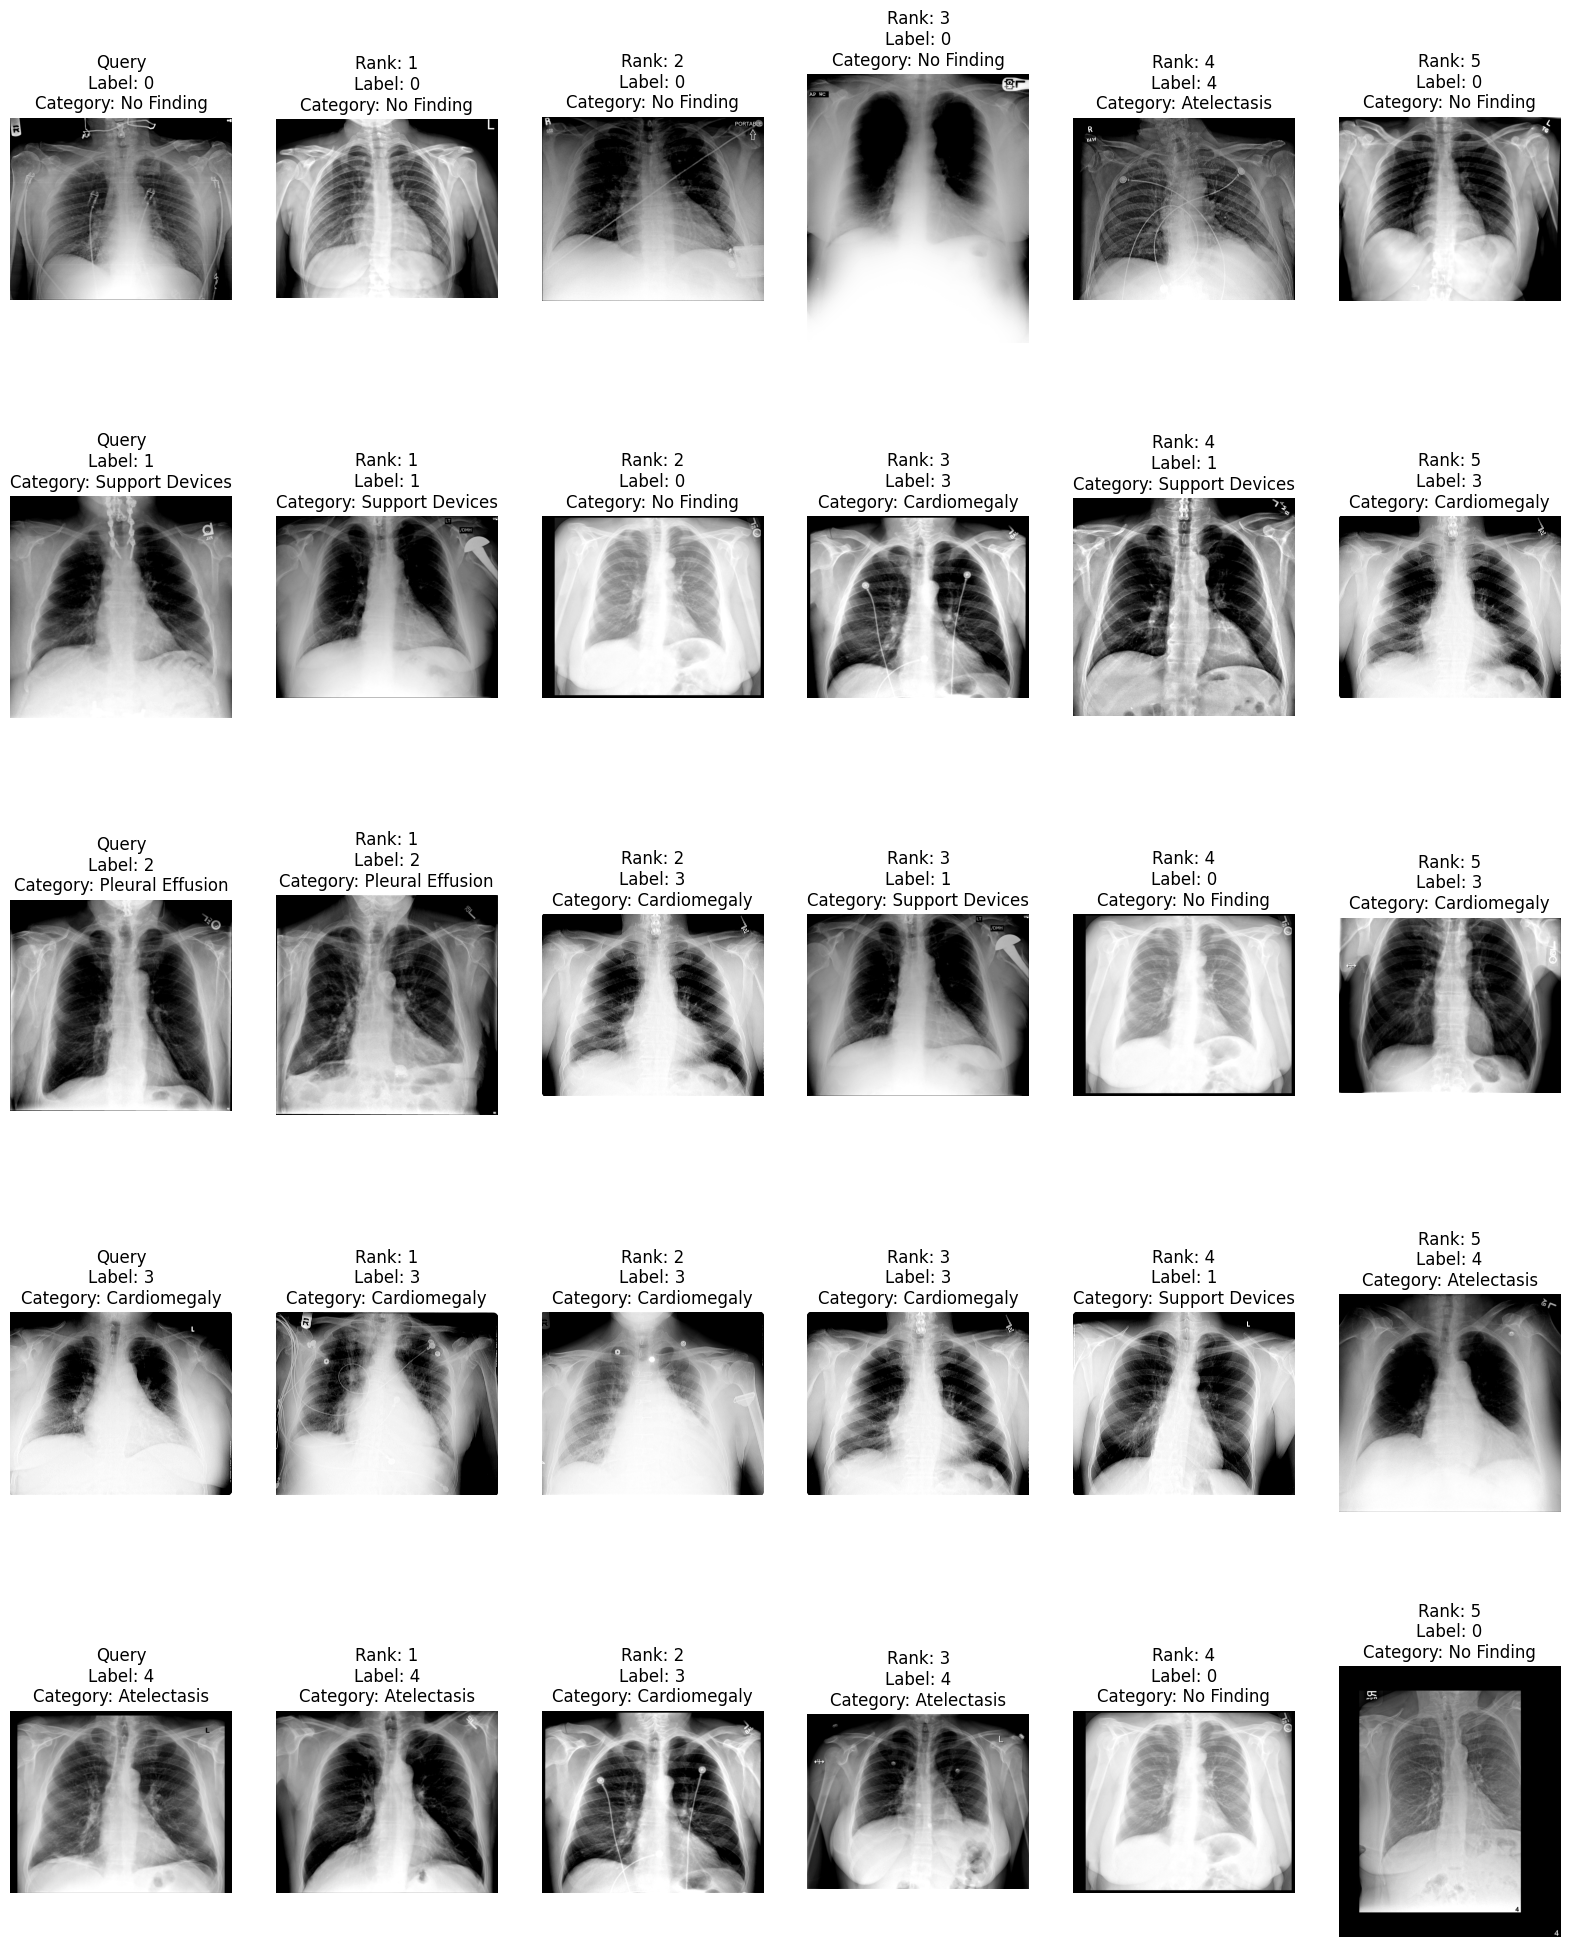

In [ ]:
from search_utils import display_query_and_retrieved_images

# Select one sample per label for visualization
query_df = test_features_df.groupby("Label").first().reset_index()
display_query_and_retrieved_images(
    query_df, mi2_search_results_df, cx_image_path, train_features_df
)

## **4. Optimize Image Search**
Now that we have seen the baseline performance, you might be wondering - what if I want to improve it and make my system optimize search for a particular criteria? That is a great question because the MI2 model creates representations that might not necessarily be perfectly aligned with search criteria that are important to you. 

Let's optimize the performance in this section. Here we will train an adapter model (as described in the [corresponding notebook](../../medimageinsight/adapter-training.ipynb) in this repository) and set up the training set to include the labels for the different pathologies that we have in our dataset. After this our embeddings generated by MI2 model paired with adapter should be aligned better with these pathologies. 

### 4.1 Define data loaders to iterate over the MI2 embeddings.


In [ ]:
from search_utils import create_data_loader_from_df

# Create DataLoaders for train and validation sets
train_mi2_ds = create_data_loader_from_df(train_features_df, mode="train")
test_mi2_ds = create_data_loader_from_df(test_features_df, mode="val")

### 4.2 Train the adapter 

We define the **adapter model** for fine-tuning the embeddings. The model takes 1024 input channels and outputs embeddings of size 254, with 5 output classes. The **CrossEntropyLoss** is used as the loss function for classification tasks, and the **AdamW** optimizer is applied with a learning rate of 0.0003. The model does not require a lot of resources to train and we trained it for 15 epochs (~30 seconds) using a CPU VM [Standard_E4s_v3](https://learn.microsoft.com/en-us/azure/virtual-machines/ev3-esv3-series) (4 cores, 32 GB RAM, 64 GB disk).

Note that the adapter model itself is defined in our _healthcareai_toolkit_ utility package that is provided alongside this notebook.

In [ ]:
## Define the model, transforms, optimizer and loss function
adapter_emb_size = 254

model = AdapterModel(in_channels=1024, hidden_dim=adapter_emb_size, num_class=5)
loss_function_ts = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003)

## Define Output Directory
output_dir = os.path.join("./medimageinsight_tutorial_output", "adaptor_model")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

max_epoch = 15
best_accuracy, best_auc = training.trainer(
    train_mi2_ds,
    test_mi2_ds,
    model,
    loss_function_ts,
    optimizer,
    epochs=max_epoch,
    root_dir=output_dir,
)
print(f"Best Accuracy of the Adaptor: {best_accuracy:.4f}")
print(f"Best AUC of the Adaptor: {best_auc:.4f}")

Current epoch: 15 Current AUC: 0.9072 Current accuracy: 0.6500 Best AUC: 0.9428 Best accuracy: 0.7500 at epoch: 7
Total Training Time: 00:00:25.10
Training completed, best_metric: 0.9428 at epoch: 7
Best Accuracy of the Adaptor: 0.7500
Best AUC of the Adaptor: 0.9428


### 4.3 Run Inference  

Next, since we have a new embedding model (the pairing of MI2 and our freshly trained adapter) we need to regenerate our FAISS index so that it stores the optimized embeddings. The code below will generate the optimized embeddings by running inference with the trained adapter model. Note that we do not need to run the images through MI2 model again, we only need to take the existing MI2 embeddings and run them through our adapter model which requires a lot less computations and requires no calls to the model API endpoint!

In [ ]:
from search_utils import perform_inference_and_return_features

train_mi2_ds.dataset.mode = "test"
test_mi2_ds.dataset.mode = "test"

test_adapter_features_dict = perform_inference_and_return_features(model, test_mi2_ds)
train_adapter_features_dict = perform_inference_and_return_features(model, train_mi2_ds)

Inference: 100%|███████████████████████████████| 80/80 [00:00<00:00, 225.24it/s]


### 4.4 Index Optimized Embeddings with Metadata  
To keep the data organized, we add the optimized embeddings to both the training and testing dataframes, along with the corresponding metadata.

In [ ]:
train_adapter_features_list = []
train_adapter_name_list = []

for v in train_adapter_features_dict:
    train_adapter_features_list.append(
        np.reshape(np.array(v["Features"]), (adapter_emb_size,))
    )
    train_adapter_name_list.append(v["Name"])

mi2_adapter_features_inference_df = pd.DataFrame(
    {
        "Name": train_adapter_name_list,
        "mi2_adapter_features": train_adapter_features_list,
    }
)

test_adapter_features_list = []
test_adapter_name_list = []

for v in test_adapter_features_dict:
    test_adapter_features_list.append(
        np.reshape(np.array(v["Features"]), (adapter_emb_size,))
    )
    test_adapter_name_list.append(v["Name"])

mi2_adapter_features_inference_test_df = pd.DataFrame(
    {
        "Name": test_adapter_name_list,
        "mi2_adapter_features": test_adapter_features_list,
    }
)

train_features_df = pd.merge(
    train_features_df, mi2_adapter_features_inference_df, on="Name", how="inner"
)
test_features_df = pd.merge(
    test_features_df, mi2_adapter_features_inference_test_df, on="Name", how="inner"
)

### 4.5 Generate FAISS Index and Evaluate Search Results  
We create a new FAISS index using the optimized embeddings and then evaluate the search results to assess the improvements in retrieval accuracy.

In [ ]:
# Create the FAISS index for mi2_adapter_features
mi2_adapter_index = create_faiss_index(train_features_df, "mi2_adapter_features")

(
    adapter_summary_df,
    adapter_detail_df,
    adapter_search_results_df,
) = evaluate_faiss_search(
    mi2_adapter_index,
    test_features_df,
    train_features_df,
    [1, 3, 5],
    query_column_feature_name="mi2_adapter_features",
)

display(adapter_detail_df)
display(adapter_summary_df)

,Label,Category,Accuracy @ k=1,Accuracy @ k=3,Accuracy @ k=5
0,0,No Finding,0.500000,0.666667,0.650000
1,1,Support Devices,0.800000,0.800000,0.760000
2,2,Pleural Effusion,0.666667,0.611111,0.566667
3,3,Cardiomegaly,1.000000,0.888889,0.800000
4,4,Atelectasis,1.000000,1.000000,1.000000


,k (Top-K),Overall Accuracy
0,1,0.793333
1,3,0.793333
2,5,0.755333


We display the optimized search results to compare the performance of the baseline and optimized models. Since the optimized index now contains embeddings that have been specifically created with target labels in mind, the optimized model should retrieve more relevant images, enhancing the accuracy of the search engine. This comparison helps us evaluate the impact of the optimization process, showing how a simple adaptation of the embeddings improves the system's ability to find clinically relevant images. Reflecting on the results, we can identify areas of further improvement, such as refining the adapter model or expanding the dataset to achieve even better performance in real-world applications.


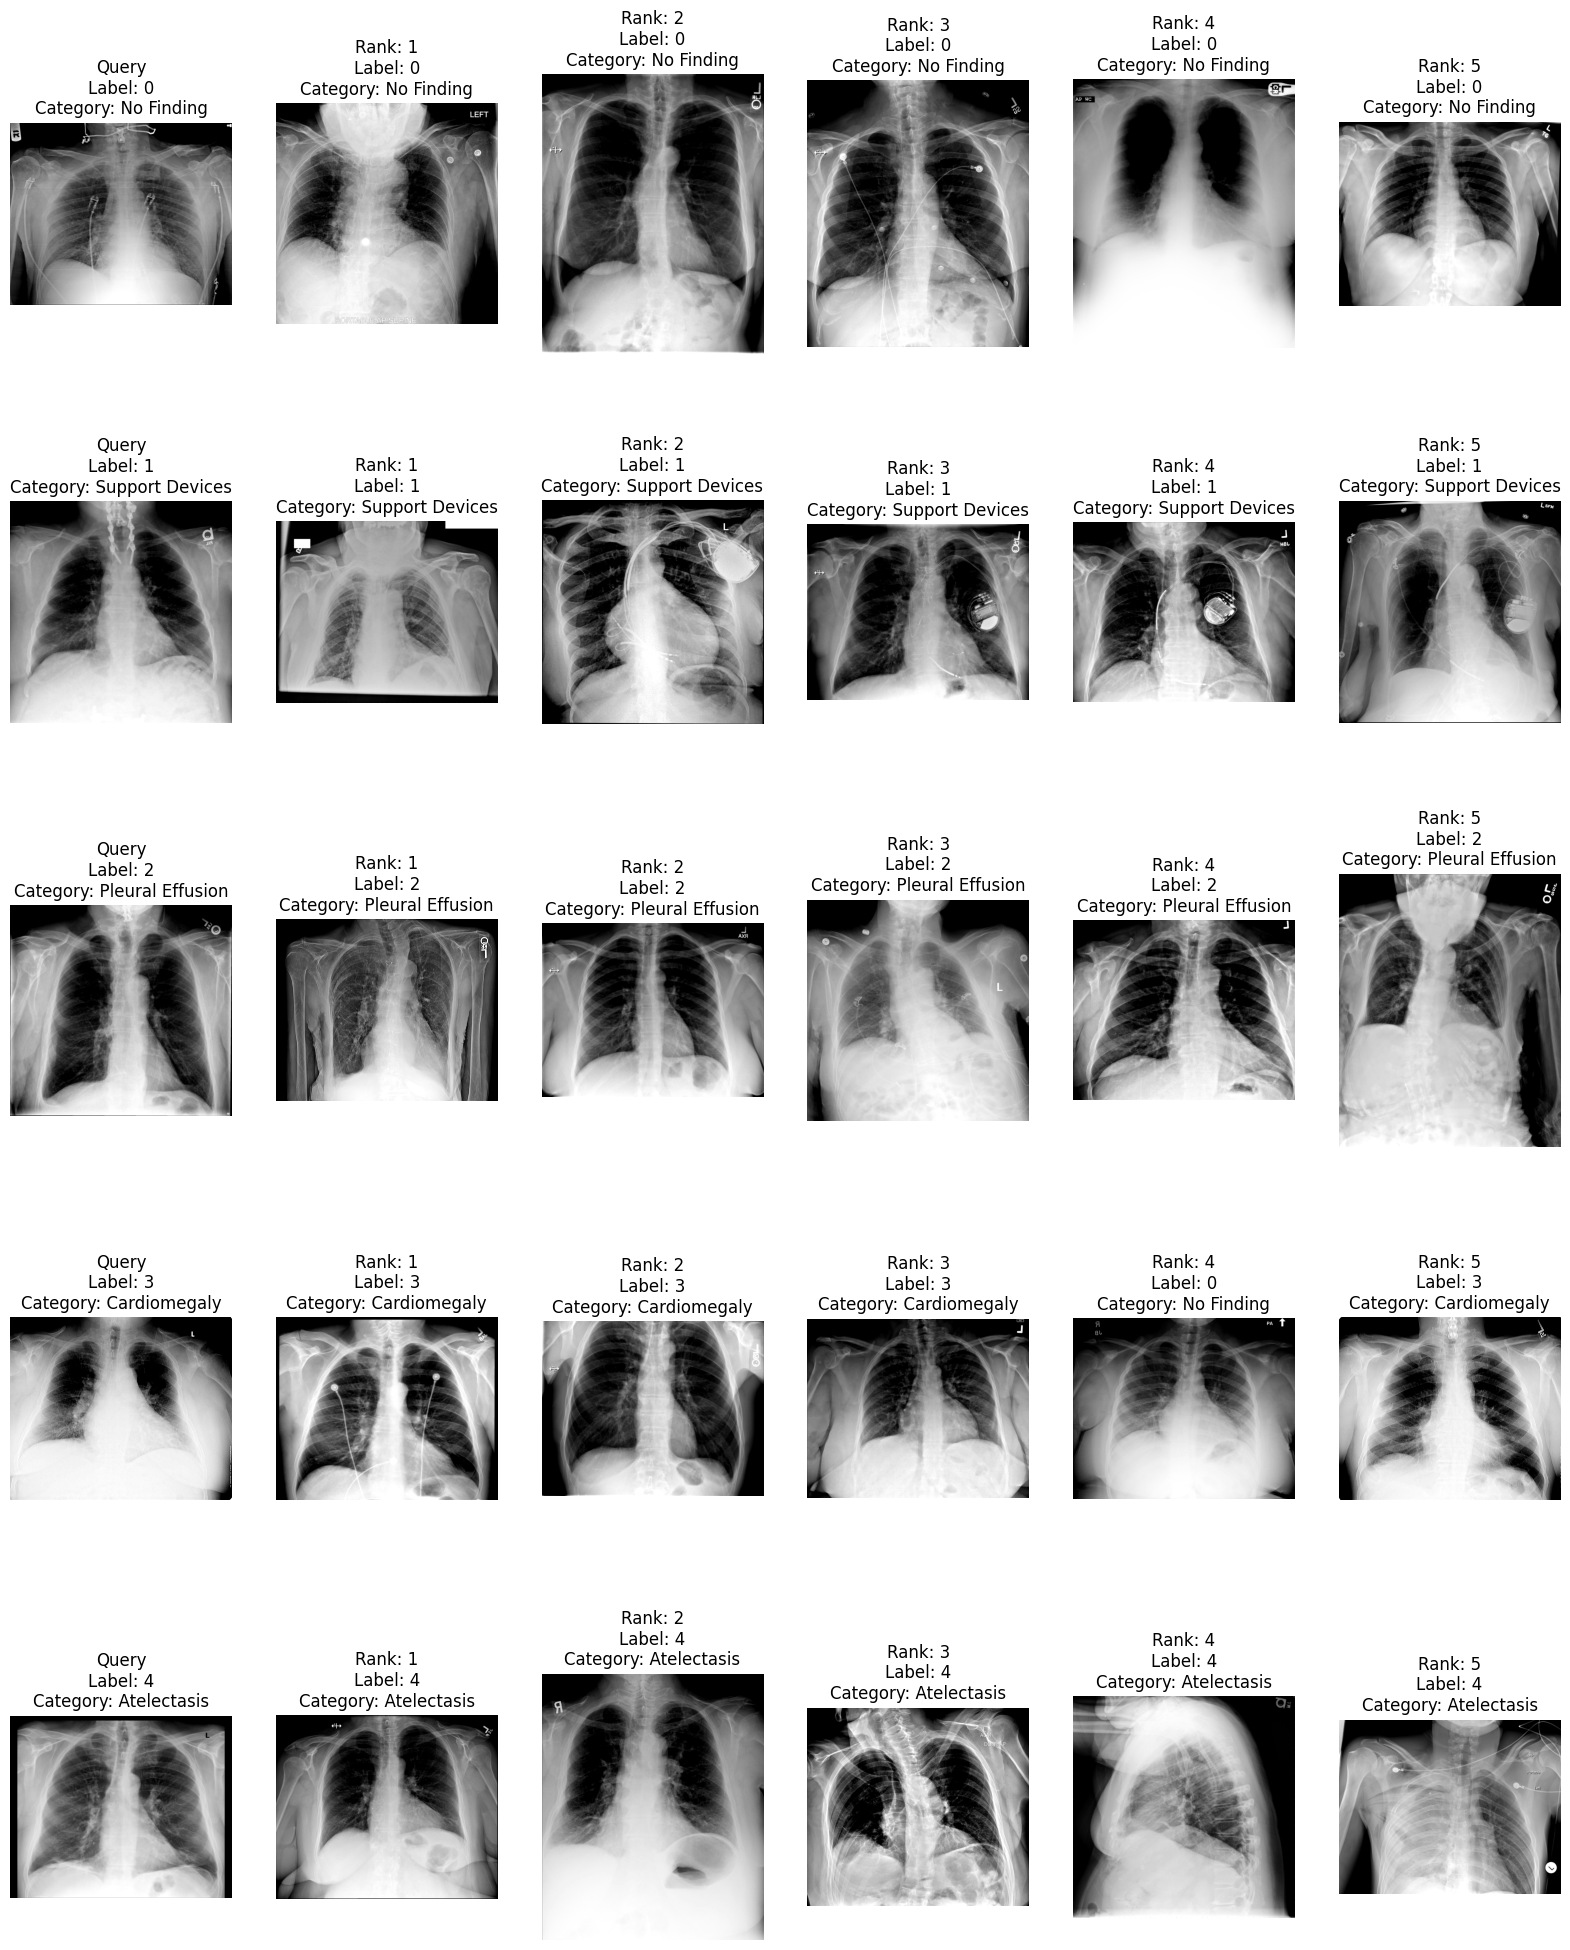

In [ ]:
display_query_and_retrieved_images(
    query_df, adapter_search_results_df, cx_image_path, train_features_df
)

## Key Takeaways

This tutorial demonstrated how to build and optimize a 2D image search system for chest X-rays using MedImageInsight (MI2) embeddings and FAISS. By refining the embeddings with an adapter model, we significantly improved search accuracy, resulting in more relevant image retrieval.

The results highlight the potential of optimized image search systems to enhance workflows. This proof-of-concept lays the groundwork for more advanced, scalable image search systems that could be applied to real-world healthcare applications. Future work could involve expanding the dataset, testing different indexing methods, and incorporating multi-label classification to further refine search capabilities and meet clinical needs.

## Summary

- We presented a simple, effective proof-of-concept for a 2D image search system using **MedImageInsight embeddings**.
- **FAISS indexing** and evaluation metrics like precision @1, @3, and @5 played a key role in measuring the performance improvements from embedding optimization.
- **Optimized embeddings**, generated by the **adapter model**, significantly enhanced the search engine’s accuracy, leading to more clinically relevant image retrieval compared to the baseline model.
- Training a simple the adapter model provided an efficient way to adjust embeddings for specific pathology classes, improving the clinical relevance of the results.
- This proof-of-concept serves as a solid foundation for developing more sophisticated, scalable 2D image search systems with applications in real-world healthcare settings.
- Future improvements could involve expanding the dataset, experimenting with alternative indexing techniques, and incorporating multi-label classification for more comprehensive image searches.

Be on the lookout for more content in the Image Search Series where we explore applications in other imaging modalities and translating these concepts into the 3D world!
